<img src="./images/DLI_Header.png" style="width: 400px;">

# 5.0 컴퓨터 비전을 위한 다중 노드 분산 학습

이번 실습에서는 분산 모드에서 간단한 이미지 분류기를 학습하는 방법에 대해 알아보겠습니다.
우리는 먼저 바닐라 파이프라인 병렬 분산을 구현할 것입니다. 그런 다음 모델 배포 및 최적화 기술을 위해 마이크로소프트의 [DeepSpeed Library](https://www.deepspeed.ai/)를 사용합니다.

## 목표

이번 노트북의 목표는 다음과 같습니다 :
* 바닐라 CNN을 트레이닝하는 방법
* DeepSpeed 라이브러리 코드 포팅하기 
* 데이터 병렬화 분산을 활용하여 트레이닝 스케일링하기
* DeepSpeed 오토 튜닝 및 ZeRO(Zero Redundancy Optimizer) 도구를 사용하여 학습 최적화


**[5.1 CIFAR-10에서 이미지 분류를 위한 합성곱 신경망](#1.1-The-hardware-overview)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.1 데이터세트](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.2 합성곱 신경망](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1.3 단순한 모델 분산](#1.1.3-Check-The-Interconnect-Topology)<br>
**[5.2 DeepSpeed로 분산 학습](#1.1-The-hardware-overview)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.1 DeepSpeed로 코드 실행하기](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.2 데이터 병렬화로 트레이닝 스케일링 하기](#1.1.3-Check-The-Interconnect-Topology)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2.3 ZeRO (Zero Redundancy Optimizer) ](#1.1.3-Check-The-Interconnect-Topology)<br>

### 기존 실행 중이거나 보류 상태의 Job을 취소니다. 

실습 진행에 앞서  SLURM 대기열에서 아직 실행 중이거나 대기 중인 작업이 없는지 확인하십시오. 다음 셀을 실행하여 SLURM 작업 대기열을 확인합니다. :


In [1]:
# Check the SLURM jobs queue 
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


아직 실행 중이거나 보류 중인 작업이 있는 경우 다음 셀을 실행하고 `scancel` 명령을 사용하여 모든 사용자의 작업을 취소합니다.

In [2]:
# Cancel admin user jobs
! scancel -u $USER

# Check again the SLURM jobs queue (should be either empty, or the status TS column should be CG)
! squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


---
# 5.1 CIFAR-10에서 이미지 분류를 위한 합성곱 신경망

## 5.1.1 데이터세트


[CIFAR-10 데이터세트](https://www.cs.toronto.edu/~kriz/cifar.html)는 6만개의 이미지(훈련용 5만, 테스트용 1만)로 구성됩니다. 데이터세트는 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 등 10가지 클래스로 분류된 32x32 픽셀 이미지입니다.
이번 실습에서, 우리는 CIFAR-10 이미지를 분류하기 위한 간단한 합성곱 신경망을 훈련시킬 것입니다.

데이터세트를 다운로드하기 위해 Computer Vision을 위한 인기 데이터 세트, 모델 아키텍처 및 공통 이미지 변환을 포함하는 Pytorch 라이브러리인  [Torchvision](https://pytorch.org/vision/stable/index.html)  패키지를 사용합니다.
<img src="images/CIFAR-10.jpg" width="350" />

먼저 다음 셀을 실행하여 관련 라이브러리를 가져오겠습니다.

In [3]:
# import the relevant libraries
import torch
import torchvision
from IPython.display import display_html

def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

# define an image tranform 
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

다음 2개의 셀을 실행하여 훈련 및 테스트용 CIFAR10 코퍼스를 다운로드합니다.

In [4]:
# Download the CIFAR10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# Download the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified


데이터세트의 몇 가지 예시를 살펴보겠습니다.:

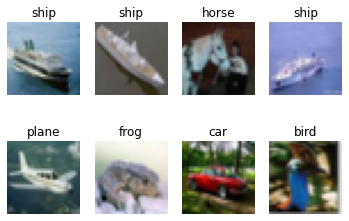

In [6]:
# Show some random training images
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels):
    for i in range(8): 
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.subplot(2,4,i+1)
        plt.imshow(np.transpose(npimg, (1, 2 , 0)));
        plt.axis('off');
        plt.title(classes[labels[i]])

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images
imshow(images,labels)

## 5.1.2 합성곱 신경망

2개의 컨볼루션 레이어로 신경망을 정의합니다. 먼저 풀링 레이어를 정의한 후 3개의 완전히 연결된 레이어를 정의하겠습니다.

In [7]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net = CNN_Net()


In [8]:
# Copy the model to GPU 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_net.to(device)

CNN_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
# Let's have a look at the Convolutional Neural Network
from torchsummary import summary
summary(cnn_net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


옵티마이저와 하이퍼 파라미터를 정의합니다. 우리는 모멘텀 옵티마이저와 함께 확률적 경사 하강법(SGD)을 사용할 것입니다.

In [10]:
# Define the hyperparameters
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Tensorboard event recording directory 
writer = SummaryWriter('megatron/tensorboard/cifar10')

log_interval=100
batch_size=64
epochs=2

In [11]:
# Train the CNN
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()     
        
        # print the loss and accuracy metrics very log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)

print('Training Done')
writer.add_graph(cnn_net, inputs)
writer.flush()
writer.close()

[epoch 0, iterations   100] loss: 2.304 accuracy: 10.515625 %
[epoch 0, iterations   200] loss: 2.303 accuracy: 10.875000 %
[epoch 0, iterations   300] loss: 2.302 accuracy: 10.833333 %
[epoch 0, iterations   400] loss: 2.300 accuracy: 11.058594 %
[epoch 0, iterations   500] loss: 2.299 accuracy: 11.315625 %
[epoch 0, iterations   600] loss: 2.296 accuracy: 11.773438 %
[epoch 0, iterations   700] loss: 2.293 accuracy: 12.107143 %
[epoch 0, iterations   782] loss: 2.286 accuracy: 12.492000 %
[epoch 1, iterations   100] loss: 2.276 accuracy: 16.953125 %
[epoch 1, iterations   200] loss: 2.254 accuracy: 18.023438 %
[epoch 1, iterations   300] loss: 2.224 accuracy: 18.838542 %
[epoch 1, iterations   400] loss: 2.187 accuracy: 19.574219 %
[epoch 1, iterations   500] loss: 2.145 accuracy: 20.193750 %
[epoch 1, iterations   600] loss: 2.113 accuracy: 20.656250 %
[epoch 1, iterations   700] loss: 2.089 accuracy: 21.035714 %
[epoch 1, iterations   782] loss: 2.051 accuracy: 21.410000 %
Training

### Tensorboard에서 학습 과정을 모니터링하고 모델을 검사합니다. 

우리는 이전 CNN 트레이닝 시, Tensorboard 이벤트를 기록하기 위한 인수 값을 설정합니다. 훈련 로스는 `cifar10`이라는 이름으로 확인 가능합니다. 또한 모델을 시각화하고 "Graphs" 탭에서 해당 레이어 전체를 탐색할 수 있습니다.

<img src="images/CNN.png" width="750"/>

다음 셀을 실행하여 브라우저용 Tensorboard 링크를 만듭니다. 그런 다음 링크를 클릭하면 지정된 `Tensorboard` 디렉토리에 저장된 실험 수치 그래프들을 볼 수 있습니다.

In [13]:
%%js
const href = window.location.hostname +'/tensorboard/';
let a = document.createElement('a');
let link = document.createTextNode('Open Tensorboard!');
a.appendChild(link);
a.href = "http://" + href;
a.style.color = "navy"
a.target = "_blank"
element.append(a);

<IPython.core.display.Javascript object>

### 훈련된 모델을 평가합니다.

CIFAR-10 테스트 데이터 세트에서 훈련된 모델을 평가해 보겠습니다. 다음 셀을 실행하여 테스트 데이터 세트의 정확도를 평가합니다. 클래스별 정확도 세부 정보도 표시됩니다.

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %2f %%' %
      (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s : %2f %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of the network on the 10000 test images: 25.000000 %
Accuracy of plane : 46.428571 %
Accuracy of   car : 14.000000 %
Accuracy of  bird : 1.265823 %
Accuracy of   cat : 16.438356 %
Accuracy of  deer : 0.000000 %
Accuracy of   dog : 30.508475 %
Accuracy of  frog : 78.571429 %
Accuracy of horse : 6.250000 %
Accuracy of  ship : 25.862069 %
Accuracy of truck : 47.435897 %


# 5.1.3 단순 모델 분산

이제 이전의 CNN 모델을 활용하여 단순 파이프라인 병렬 분포를 구현해 보겠습니다. 그러기 위해서는, 각 레이어를 디바이스에 명시적으로 배치하고 순방향 패스를 구현하여 해당 출력을 디바이스와 일치시켜야 합니다.



우리는 두 개의 GPU에서 CNN 모델을 실행합니다. 이때, GPU0에 conv1 + pooling을 배치하고 GPU1에 conv2 + fc1 + fc2 + fc3를 배치하겠습니다.
우리는 텐서를 cuda로 변환하여 원하는 장치에 배치하기 위해 토치 *[TORCH.TENSOR.TO](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to)* 를 사용합니다. 

정의된 `Net_Parallel`클래스에서 수정된 클래스를 살펴봅니다.

In [15]:
# Define the CNN
import torch.nn as nn
import torch.nn.functional as F

class Net_Parallel(nn.Module):
    def __init__(self):
        super(Net_Parallel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5).to('cuda:0')               # Changed here
        self.pool = nn.MaxPool2d(2, 2).to('cuda:0')                # Changed here
        self.conv2 = nn.Conv2d(6, 16, 5).to('cuda:1')              # Changed here
        self.fc1 = nn.Linear(16 * 5 * 5, 120).to('cuda:1')         # Changed here
        self.fc2 = nn.Linear(120, 84).to('cuda:1')                 # Changed here
        self.fc3 = nn.Linear(84, 10).to('cuda:1')                  # Changed here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.to('cuda:0'))))          # Changed here
        x = self.pool(F.relu(self.conv2(x.to('cuda:1'))))          # Changed here
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_net_pp = Net_Parallel()

이전 훈련 실행과 마찬가지로 다음 2개의 셀을 실행하여 옵티마이저/하이퍼 매개 변수를 정의한 다음 훈련을 시작합니다.

In [16]:
# Define the hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net_pp.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Tensorboard event recording directory 
writer_pp = SummaryWriter('megatron/tensorboard/cifar10_PP')                 

log_interval=100
batch_size=64
epochs=2

다음 셀을 실행하여 터미널을 열고 watch `nvidia-smi` 명령어를 실행하면 GPU 활동을 확인할 수 있습니다.

In [17]:
%%html

<pre>
   Step 1: Open a terminal session by following the <a href="", data-commandlinker-command="terminal:create-new">Terminal link</a>
   Step 2: Check the GPUs: <font color="green">watch nvidia-smi</font>
</pre

터미널 창을 열어두고 다음 학습을 실행하십시오.

In [18]:
# Train the CNN with pipeline parallel
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_net_pp(inputs.to('cuda:0'))                                # Changed here
        loss = criterion(outputs, labels.to('cuda:1'))                           # Changed here
        # Backward pass
        loss.backward()
        optimizer.step()
        torch.cuda.reset_max_memory_allocated(0)
        # print the loss and accuracy metrics very log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.to('cuda:1')).sum().item()                 # Changed here
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer_pp.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer_pp.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)

print('Training Done')
writer_pp.add_graph(cnn_net_pp, inputs)
writer_pp.flush()
writer_pp.close()

/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


[epoch 0, iterations   100] loss: 2.304 accuracy: 9.812500 %
[epoch 0, iterations   200] loss: 2.303 accuracy: 9.960938 %
[epoch 0, iterations   300] loss: 2.302 accuracy: 9.854167 %
[epoch 0, iterations   400] loss: 2.301 accuracy: 9.917969 %
[epoch 0, iterations   500] loss: 2.299 accuracy: 10.871875 %
[epoch 0, iterations   600] loss: 2.298 accuracy: 11.333333 %
[epoch 0, iterations   700] loss: 2.296 accuracy: 11.754464 %
[epoch 0, iterations   782] loss: 2.293 accuracy: 12.148000 %
[epoch 1, iterations   100] loss: 2.288 accuracy: 18.484375 %
[epoch 1, iterations   200] loss: 2.277 accuracy: 19.242188 %
[epoch 1, iterations   300] loss: 2.258 accuracy: 19.072917 %
[epoch 1, iterations   400] loss: 2.226 accuracy: 19.277344 %
[epoch 1, iterations   500] loss: 2.170 accuracy: 19.784375 %
[epoch 1, iterations   600] loss: 2.115 accuracy: 20.393229 %
[epoch 1, iterations   700] loss: 2.062 accuracy: 21.015625 %
[epoch 1, iterations   782] loss: 2.031 accuracy: 21.504000 %
Training Don

# 5.2 DeepSpeed 분산 학습

DeepSpeed 라이브러리는 단일 GPU에서 로우앤드 클러스터, 거대한 슈퍼컴퓨터에 이르는 다양한 하드웨어 크기에 대한 분산 학습을 위한 딥 러닝 최적화 라이브러리입니다.

<img src="https://www.deepspeed.ai/assets/images/3d-parallelism.png" width="650" />


- 단일 GPU/멀티 GPU/멀티 노드에 대한 혼합 정밀도의 분산 학습
- 파이프라인 병렬화 및 메가트론-LM 텐서 병렬화와의 통합 
- ZeRO(Zero Redundancy Optimizer) 메모리 최적화 기술
- Zero-Offload 데이터 및 연산 CPU 오프로드
- Mixture of Experts(MoE)

## 5.2.1 DeepSpeed로 코드 실행하기

DeepSpeed 엔진은 `torch.nn.module`로 정의된 신경망을 감쌀 수 있습니다. DeepSpeed를 사용하여 이전 모델을 작성하려면 다음과 같은 작업이 필요합니다.

- DeepSpeed Model 엔진과 옵티마이저를 인스턴스화 합니다. : DeepSpeed 이니셜라이저를 다음과 같이 사용합니다. 
`model_engine, optimizer= deepspeed.initialize(args=args, model=Your_Network, model_parameters=parameters, training_data=trainset)`
- 변수`args` 는 훈련 인자와 DeepSpeed 인자를 포함해야 합니다. `deepspeed.add_config_arguments(parser)`를 사용하여 DeepSpeed 인수를 파서에 추가할 수 있습니다.
- 코드의 나머지 부분에 있는 `Your_Network` 대신 deepspeed `model_engine`을 참조하십시오.
`torch.distributed.init_process_group(...)`를 활용한 분산 학습 구현을 `deepspeed.init_distributed()`로 대체합니다.

[전용 DeepSpeed 설명서](https://www.deepspeed.ai/getting-started/#writing-deepspeed-models) 를 사용하여 DeepSpeed 모델을 작성하는 방법에 대해 자세히 알아보십시오.

DeepSpeed 인수들은 JSON 구성 파일 전체에 전달할 수 있습니다. DeepSpeed 구성 파일을 살펴보겠습니다.

In [19]:
# Have a look at the DeepSpeed config
! cat code/moe/ds_config.json

{
  "train_batch_size": 16,
  "steps_per_print": 2000,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.001,
      "betas": [
        0.8,
        0.999
      ],
      "eps": 1e-8,
      "weight_decay": 3e-7
    }
  },
  "scheduler": {
    "type": "WarmupLR",
    "params": {
      "warmup_min_lr": 0,
      "warmup_max_lr": 0.001,
      "warmup_num_steps": 1000
    }
  },
  "gradient_clipping": 1.0,
  "prescale_gradients": false,
  "fp16": {
      "enabled": true,
      "fp16_master_weights_and_grads": false,
      "loss_scale": 0,
      "loss_scale_window": 500,
      "hysteresis": 2,
      "min_loss_scale": 1,
      "initial_scale_power": 15
  },
  "wall_clock_breakdown": false,
  "zero_optimization": {
      "stage": 0,
      "allgather_partitions": true,
      "reduce_scatter": true,
      "allgather_bucket_size": 50000000,
      "reduce_bucket_size": 50000000,
      "overlap_comm": true,
      "contiguous_gradients": true,
      "cpu_offload": false
  } 

}

In [20]:
# import the relevant library
import deepspeed

# define the argument classe embedding our training arguments and DeepSpeed
class Args:
    log_interval=100 
    batch_size=64
    epochs=2
    deepspeed = True
    deepspeed_config = "code/moe/ds_config.json"
    local_rank= 0

args=Args()

In [21]:
# define the CNN network
cnn_net_ds = CNN_Net()

# Define the hyperparameters
parameters = filter(lambda p: p.requires_grad, cnn_net_ds.parameters())

# Wrap the CNN network with DeepSpeed
model_engine, optimizer, _, _ = deepspeed.initialize(args=args, model=cnn_net_ds, model_parameters=parameters, training_data=trainset)

# enable mixed precision
fp16 = model_engine.fp16_enabled()

device = model_engine.local_rank
criterion = nn.CrossEntropyLoss()

# Tensorboard event recording directory 
writer_ds = SummaryWriter('megatron/tensorboard/cifar10_DS')                 

[2025-03-28 03:35:13,978] [INFO] [logging.py:69:log_dist] [Rank -1] DeepSpeed info: version=0.6.5, git-hash=unknown, git-branch=unknown
[2025-03-28 03:35:13,979] [INFO] [distributed.py:36:init_distributed] Not using the DeepSpeed or torch.distributed launchers, attempting to detect MPI environment...
[2025-03-28 03:35:14,255] [INFO] [distributed.py:85:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.18.0.5, master_port=29500
[2025-03-28 03:35:14,256] [INFO] [distributed.py:48:init_distributed] Initializing torch distributed with backend: nccl
[2025-03-28 03:35:14,671] [INFO] [engine.py:278:__init__] DeepSpeed Flops Profiler Enabled: False
Using /home/admin/.cache/torch_extensions/py38_cu115 as PyTorch extensions root...
Creating extension directory /home/admin/.cache/torch_extensions/py38_cu115/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/admin/.cache/torch_extensions/py38_cu115/fused_adam/build.n

In [22]:
# Train the CNN with DeepSpeed
for epoch in range(epochs): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        if fp16:
            inputs = inputs.half()        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_engine(inputs)             # Changed net_cnn to model_engine
        loss = criterion(outputs, labels)
        
        # Backward pass
        model_engine.backward(loss)                # Changed net_cnn to model_engine
        model_engine.step()                        # Changed net_cnn to model_engine
        
        # print the loss and accuracy metrics very log_interval mini-batches
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        if i % log_interval == (log_interval - 1):  
            print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / log_interval, 100.*correct/total))
            writer_ds.add_scalar("Training Cross Entropy Loss", running_loss / log_interval, i + 1)
            writer_ds.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
            running_loss = 0.0
            
    # print the last iterations 
    print('[epoch %d, iterations %5d] loss: %.3f accuracy: %2f %%' %  (epoch , i + 1, running_loss / ((i % log_interval) + 1), 100.*correct/total))
    writer.add_scalar("Training Cross Entropy Loss", running_loss / ((i % log_interval) + 1), i + 1)
    writer.add_scalar("Training Accuracy", 100.*correct/total, i + 1)
    
print('Training Done')
writer_ds.add_graph(model_engine, inputs)
writer_ds.flush()
writer_ds.close()

[epoch 0, iterations   100] loss: 2.152 accuracy: 19.609375 %
[epoch 0, iterations   200] loss: 1.917 accuracy: 24.585938 %
[epoch 0, iterations   300] loss: 1.795 accuracy: 27.958333 %
[epoch 0, iterations   400] loss: 1.699 accuracy: 30.527344 %
[epoch 0, iterations   500] loss: 1.641 accuracy: 32.475000 %
[2025-03-28 03:36:22,010] [INFO] [fused_optimizer.py:392:_update_scale] No Grad overflow for 500 iterations
[2025-03-28 03:36:22,011] [INFO] [fused_optimizer.py:394:_update_scale] Increasing dynamic loss scale from 32768 to 65536
[2025-03-28 03:36:22,017] [INFO] [fused_optimizer.py:382:_update_scale] 
Grad overflow on iteration 501
[2025-03-28 03:36:22,018] [INFO] [fused_optimizer.py:383:_update_scale] Reducing dynamic loss scale from 65536 to 32768.0
[2025-03-28 03:36:22,018] [INFO] [logging.py:69:log_dist] [Rank 0] Overflow detected. Skipping step. Attempted loss scale: 65536, reducing to 32768.0
[epoch 0, iterations   600] loss: 1.570 accuracy: 34.252604 %
[epoch 0, iterations  

이전 단계들은 python 스크립트 [cifar10_deepspeed.py](./code/moe/cifar10_deepspeed.py) 로 집계됩니다.

## 5.2.2 데이터 병렬화를 활용한 스케일 아웃 트레이닝

이제 분산 학습 기법을 사용하여 이전에 진행한 트레이닝을 확장해 보겠습니다. 데이터 병렬화 분산을 활용하여 4개의 GPU에서 이전 코드를 실행하려면 torch.distributed.launch 명령어를 사용하는 대신 deepspeed를 도입하면 됩니다.

`python -m torch.distributed.launch --nproc_per_node=4 my_code.py <args>`

DeepSpeed를 사용하려면 단순히 torch.distributed.launch를 deepspeed로 바꾸고 새 인수(--deepspeed ds_config.json)를 추가하면 됩니다.

`deepspeed --num_gpus=4 my_code.py  <args> --deepspeed ds_config.json`

다음 셀을 실행하여 DeepSpeed가 포함된 4개의 GPU에서 이전 cifar10_deepspeed.py 트레이닝 코드를 실행합니다:

In [23]:
# Kill zombie processes
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run the training on 4 GPUs with Data parallel
! deepspeed --num_gpus=4 /dli/code/moe/cifar10_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config.json \
    --profile-execution=True \
    --profile-name='zero0'

[2025-03-28 03:37:47,682] [WARNING] [runner.py:159:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2025-03-28 03:37:47,849] [INFO] [runner.py:457:main] cmd = /opt/conda/bin/python3.8 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 /dli/code/moe/cifar10_deepspeed.py --deepspeed --deepspeed_config /dli/code/moe/ds_config.json --profile-execution=True --profile-name=zero0
[2025-03-28 03:37:49,399] [INFO] [launch.py:96:main] 0 NCCL_P2P_DISABLE=1
[2025-03-28 03:37:49,399] [INFO] [launch.py:96:main] 0 NCCL_VERSION=2.11.4
[2025-03-28 03:37:49,400] [INFO] [launch.py:103:main] WORLD INFO DICT: {'localhost': [0, 1, 2, 3]}
[2025-03-28 03:37:49,400] [INFO] [launch.py:109:main] nnodes=1, num_local_procs=4, node_rank=0
[2025-03-28 03:37:49,400] [INFO] [launch.py:122:main] global_rank_mapping=defaultdict(<class 'list'>, {'localhost': [0, 1, 2, 3]})
[2025-03-28 03:37:49,400] [I

SLURM 기반 클러스터에서 동일하게 실행하려면 원하는 리소스를 할당하는 SBATCH 스크립트를 작성하고 동일한 DeepSpeed 명령어를 호출하기만 하면 됩니다. 

다음 셀을 실행하여 DeepSpeed로 이전 트레이닝을 실행할 노드 2개를 할당하는 SBATCH 스크립트를 만듭니다.

In [2]:
%%writefile /dli/code/run_cifar10_deepspeed_2Nodes.sh
#!/bin/bash
#SBATCH --job-name=dli_ds
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=1       
#SBATCH --cpus-per-task=32 ### Number of threads per task (OMP threads)
#SBATCH -o /dli/megatron/logs/%j.out
#SBATCH -e /dli/megatron/logs/%j.err

# Number of nodes
NUM_NODES=2
# Number of GPUs per node
NUM_GPUS=2


deepspeed --num_nodes=${NUM_NODES} --hostfile /dli/code/moe/hostfile --num_gpus=${NUM_GPUS} /dli/code/moe/cifar10_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config.json \
    --profile-execution=True \
    --profile-name='zero0_sbatch'

Writing /dli/code/run_cifar10_deepspeed_2Nodes.sh


이제 이전 sbatch 스크립트 [run_cifar10_deepspeed_2Nodes.sh](./code/run_cifar10_deepspeed_2Nodes.sh) 를 제출하고 `squeue` 명령어를 사용하여 SLURM 대기열을 확인합니다.

In [3]:
# Submit the 2 nodes jobs
! sbatch /dli/code/run_cifar10_deepspeed_2Nodes.sh

# Check the SLURM queue
!squeue

Submitted batch job 16
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
                16  slurmpar   dli_ds    admin  R       0:00      2 slurmnode[1-2]


In [4]:
# Check GPU utilization on the master node
! sleep 10
!nvidia-smi

Fri Mar 28 03:39:18 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   36C    P0    52W / 300W |   1010MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

## 5.2.3 ZeRO : Zero Redundancy Optimizer 

[ZeRO](https://www.deepspeed.ai/tutorials/zero/)는 모델의 트레이닝 상태(가중치, 그레이디언트 및 옵티마이져 상태값)를 사용 가능한 장치에 분산시켜 각 GPU의 메모리 소비를 줄입니다. ZeRO는 3가지 누적 단계로 구현됩니다.

-  **ZeRO-1:** 옵티마이저 상태는 프로세스 간에 분할되므로 각 프로세스는 파티션만 업데이트합니다. 예를 들어 Adam optimizer는 32비트 가중치와 첫 번째, 두 번째 모멘트 추정치를 저장합니다.
-  **ZeRO-2:** Zero 1 외에도 모델 가중치를 업데이트하기 위한 축소된 32비트 그레이디언트도 분할되어 각 프로세스는 옵티마이저 상태의 해당 부분에 해당하는 그레이디언트만 유지합니다.
- **ZeRO-3:** Zero 2 외에도 16비트 모델 매개 변수는 프로세스 전반에 걸쳐 분할됩니다. ZeRO-3는 포워드 및 백워드 패스 중에 자동으로 16비트 매개변수들을 수집 및 분할합니다. ZeRO-3에는 메모리 절감을 위해 CPU와 NVMe 메모리로 오프로드하는 [ZeRO-Infinity](https://arxiv.org/pdf/2104.07857.pdf) 엔진도 포함되어 있습니다.

```
{
 "zero_optimization": {
    "stage": [0|1|2|3],
    "allgather_partitions": [true|false],
    "allgather_bucket_size": 5e8,
    "overlap_comm": false,
    "reduce_scatter": [true|false],
    "reduce_bucket_size": 5e8,
    "contiguous_gradients" : [true|false],
    "offload_param": {
      ...
    },
    "offload_optimizer": {
      ...
    },
    "stage3_max_live_parameters" : 1e9,
    "stage3_max_reuse_distance" : 1e9,
    "stage3_prefetch_bucket_size" : 5e8,
    "stage3_param_persistence_threshold" : 1e6,
    "sub_group_size" : 1e12,
    "elastic_checkpoint" : [true|false],
    "stage3_gather_16bit_weights_on_model_save": [true|false],
    "ignore_unused_parameters": [true|false]
    "round_robin_gradients": [true|false]
    }
    }

```


<video controls src="https://www.microsoft.com/en-us/research/uploads/prod/2020/02/Turing-Animation.mp4?_=1" width="560" />

메모리 절약을 위한 ZeRO 옵티마이저의 장점을 설명하기 위해 CNN 모델을 더 큰 신경망으로 확장해 보겠습니다. 우리는 작은 CNN 네트워크를 [large_model_deepspeed.py](./code/moe/large_model_deepspeed.py) 에서 1,100만 개의 매개 변수를 가진 Resnet152 모델로 교체했습니다.

다음 그림은  *resnet152* 학습 단계에 대하여 [htop](https://htop.dev/) 명령어를 사용하여 CPU 사용량과 Pytorch Profiler (텐서보드에서 사용 가능)를 사용하여 프로파일링된 GPU 0 메모리를 보여줍니다. 우리는 no ZeRO와 ZeRO stage 3 + 오프로드 시 비교를 볼 수 있습니다. ZeRO 를 사용하지 않고 GPU 당 필요한 메모리 피크 값은 약 1.5 GB 입니다. ZeRO-3를 사용하여 매개 변수를 CPU로 오프로드하면 845MB만 사용합니다. 반면에 각 스텝 당 시간은 500ms에서 7000ms로 크게 증가했습니다!

ZeRO infinity는 GPU의 수가 제한되어 있을 때 더 큰 모델로 확장할 수 있지만, 이는 데이터 이동에 상응하는 추가 학습 시간이 수반됩니다.
<img src="images/zero_memory.png" width="1250" />


Zero stage 3 옵티마이저를 실행하고 매개 변수의 CPU 오프로드를 사용하도록 설정합니다. 우리는 구성 파일을 준비해 두었고 GPU당 트레이닝 배치 크기를 512로 늘렸습니다.

In [1]:
# Show DeepSpeed config file for Zero stage 3 Offload
! cat /dli/code/moe/ds_config_stage_3.json 

{
  "train_batch_size": 512,
  "steps_per_print": 2000,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.001,
      "betas": [
        0.8,
        0.999
      ],
      "eps": 1e-8,
      "weight_decay": 3e-7
    }
  },
  "scheduler": {
    "type": "WarmupLR",
    "params": {
      "warmup_min_lr": 0,
      "warmup_max_lr": 0.001,
      "warmup_num_steps": 1000
    }
  },
  "gradient_clipping": 1.0,
  "prescale_gradients": false,
  "fp16": {
      "enabled": true,
      "fp16_master_weights_and_grads": false,
      "loss_scale": 0,
      "loss_scale_window": 500,
      "hysteresis": 2,
      "min_loss_scale": 1,
      "initial_scale_power": 15
  },
  "wall_clock_breakdown": false,
    "zero_optimization": {
        "stage": 3,
        "cpu_offload": true,
        "cpu_offload_params": true,
        "cpu_offload_use_pin_memory" : true,
        "overlap_comm": true,
        "contiguous_gradients": true,
        "stage3_max_live_parameters": 1e9,
        "stage3_max_reus

다음 셀을 실행하여 CIFAR-10 데이터 세트에 대해 *resnet152* 모델 학습을 실행합니다. 이 실험에서는 정확도가 아니라 메모리 소비에 관심이 있기 때문에 모델을 더 이상 평가하지 않습니다.

In [4]:
! deepspeed --num_gpus=4 /dli/code/moe/large_model_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config_stage_3.json \
    --profile-execution=True \
    --profile-name='zero_resnet152_stage3'

[2025-03-28 05:07:22,746] [WARNING] [runner.py:159:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2025-03-28 05:07:22,912] [INFO] [runner.py:457:main] cmd = /opt/conda/bin/python3.8 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 /dli/code/moe/large_model_deepspeed.py --deepspeed --deepspeed_config /dli/code/moe/ds_config_stage_3.json --profile-execution=True --profile-name=zero_resnet152_stage3
[2025-03-28 05:07:24,482] [INFO] [launch.py:96:main] 0 NCCL_P2P_DISABLE=1
[2025-03-28 05:07:24,482] [INFO] [launch.py:96:main] 0 NCCL_VERSION=2.11.4
[2025-03-28 05:07:24,482] [INFO] [launch.py:103:main] WORLD INFO DICT: {'localhost': [0, 1, 2, 3]}
[2025-03-28 05:07:24,483] [INFO] [launch.py:109:main] nnodes=1, num_local_procs=4, node_rank=0
[2025-03-28 05:07:24,483] [INFO] [launch.py:122:main] global_rank_mapping=defaultdict(<class 'list'>, {'localhost': [0, 1, 2, 3]})


다음 셀을 실행하여 브라우저에서 텐서보드에 대한 링크를 만듭니다.

In [7]:
%%js
const href = window.location.hostname +'/tensorboard/';
let a = document.createElement('a');
let link = document.createTextNode('Open Tensorboard!');
a.appendChild(link);
a.href = "http://" + href;
a.style.color = "navy"
a.target = "_blank"
element.append(a);

<IPython.core.display.Javascript object>

### 실험 : ZeRO Stage 1

ZeRO Stage 1 실행 시간과 GPU/CPU 메모리 크기를 no ZeRO 및 ZeRO Stage 3 + 오프로드와 비교합니다. 우리는 이미 DeepSpeed 구성 파일을 준비해 두었습니다. 한 번 결과를 확인해 보겠습니다:

In [8]:
# Show DeepSpeed config file for Zero stage 1 
! cat /dli/code/moe/ds_config_stage_1.json 

{
  "train_batch_size": 512,
  "steps_per_print": 2000,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.001,
      "betas": [
        0.8,
        0.999
      ],
      "eps": 1e-8,
      "weight_decay": 3e-7
    }
  },
  "scheduler": {
    "type": "WarmupLR",
    "params": {
      "warmup_min_lr": 0,
      "warmup_max_lr": 0.001,
      "warmup_num_steps": 1000
    }
  },
  "gradient_clipping": 1.0,
  "prescale_gradients": false,
  "fp16": {
      "enabled": true,
      "fp16_master_weights_and_grads": false,
      "loss_scale": 0,
      "loss_scale_window": 500,
      "hysteresis": 2,
      "min_loss_scale": 1,
      "initial_scale_power": 15
  },
  "wall_clock_breakdown": false,
  "activation_checkpointing": {
      "partition_activations": false,
      "cpu_checkpointing": false,
      "contiguous_memory_optimization": false,
      "number_checkpoints": 24,
      "synchronize_checkpoint_boundary": false,
      "profile": false
    },
  "zero_optimization": {
      

Execute the next cell to run the *resnet152* model training on the CIFAR-10 dataset with ZeRO Stage1. Replace the `FIXME` with the corresponding arguments. If you get stuck, you can look at the [solution](solutions/ex5.2.4.ipynb).

In [11]:
! deepspeed --num_gpus=4 /dli/code/moe/large_model_deepspeed.py \
    --deepspeed \
    --deepspeed_config /dli/code/moe/ds_config_stage_1.json \
    --profile-execution=True \
    --profile-name='zero_resnet512_stage1'

[2025-03-28 03:44:16,936] [WARNING] [runner.py:159:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2025-03-28 03:44:17,103] [INFO] [runner.py:457:main] cmd = /opt/conda/bin/python3.8 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgM119 --master_addr=127.0.0.1 --master_port=29500 /dli/code/moe/large_model_deepspeed.py --deepspeed --deepspeed_config /dli/code/moe/ds_config_stage_1.json --profile-execution=True --profile-name=zero_resnet512_stage1
[2025-03-28 03:44:18,651] [INFO] [launch.py:96:main] 0 NCCL_P2P_DISABLE=1
[2025-03-28 03:44:18,651] [INFO] [launch.py:96:main] 0 NCCL_VERSION=2.11.4
[2025-03-28 03:44:18,651] [INFO] [launch.py:103:main] WORLD INFO DICT: {'localhost': [0, 1, 2, 3]}
[2025-03-28 03:44:18,651] [INFO] [launch.py:109:main] nnodes=1, num_local_procs=4, node_rank=0
[2025-03-28 03:44:18,651] [INFO] [launch.py:122:main] global_rank_mapping=defaultdict(<class 'list'>, {'localhost': [0, 1, 2, 3]})


Compared to the run without ZeRO, Stage 1 allows to reduce the GPU memory usage from about 1.5GB to 1GB as it partitions the optimizer states across 4 GPUs meaning that each GPU is responsible for keeping in memory a part of the optimizer states and communicate them when necessary to others. In this case, no significant extra time is observed to run the step with ZeRO Stage 1.

## 선택사항: 5.2.4 오토 튜닝

학습 실험을 설계할 때 하드웨어를 완전히 활용하고 높은 처리량을 달성하는 최적의 구성(마이크로 배치 크기 등)이 무엇인지 알기 어렵습니다. 일반적으로 하드웨어 구성 탐색은 수동으로 수행됩니다. 이러한 조정 프로세스는 번거롭고 시간이 많이 소요되며 구성은 하드웨어에 따라 다릅니다. DeepSpeed Autotuner는 학습 속도에 최적화된 DeepSpeed 구성 매개변수를 자동으로 검색합니다.
오토 튜닝을 시작하려면 학습 스크립트에  `--autotuning run`  명령을 추가하고 구성 파일에서 다음과 같이 사용하도록 설정하십시오. 

```
{
  "train_micro_batch_size_per_gpu": "auto",

  "autotuning": {
    "enabled": true,
    "arg_mappings": {
      "train_micro_batch_size_per_gpu": "--batch_size"    }
  }
}
```
DeepSpeed 구성 파일의 arg_mappings 사전(dictionary) 자동 조정 섹션은 DeepSpeed 구성의 매개 변수와 학습 스크립트 인자 간의 이름 매핑을 제공합니다. 또한  "auto" 를 평가할 수 있는 값의 벡터로 대체하여 검색 공간을 값 목록으로 제한할 수도 있습니다. 

오토 튜닝 기능에 대한 자세한 내용은 [DeepSpeed documentation](https://www.deepspeed.ai/tutorials/autotuning/)를 참조하십시오.

---
<h2 style="color:green;">축하합니다!</h2>

다음으로 넘어가기 전에 대기열에서 실행 중이거나 대기 중인 작업이 없는지 확인해야 합니다.

In [ ]:
# Check the SLURM jobs queue 
!squeue

아직 실행 중이거나 보류 중인 작업이 있는 경우 다음 셀을 실행하고 `scancel` 명령을 사용하여 모든 어드민 사용자의 작업을 취소합니다.

In [ ]:
# Cancel admin user jobs
! scancel -u $USER

# Check again the SLURM jobs queue (should be either empty, or the status TS column should be CG)
! squeue

다음으로는 MoE(Mixture of Expert) 구성을 살펴보겠습니다. [06_MOE_alternative_models.ipynb](06_MOE_alternative_models.ipynb) 로 이동합니다.